# Credit Card Fraud Detection
#### By Shadi Bavar, Matthew Euliano, and Claire Parisi


##### Importing Required Libraries & Dataset

In [49]:
#Importing the libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report, f1_score, accuracy_score, precision_score, recall_score, make_scorer 


In [50]:
#Importing the Data
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [51]:
#Show statistics
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


##### Visualization and Data Conditioning

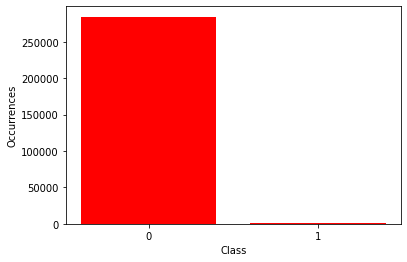

Number of fraud transactions: 492 ( 0.17 %)
Number of non-fraud transactions: 284315 ( 99.83 %)


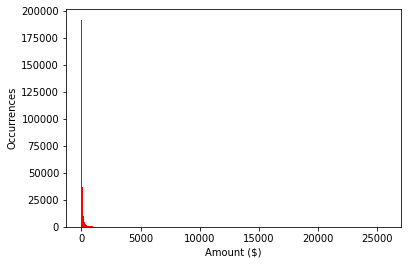

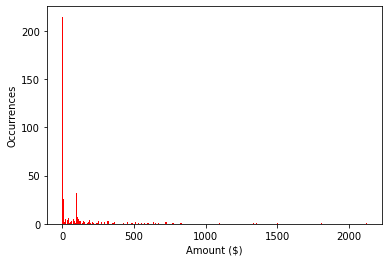

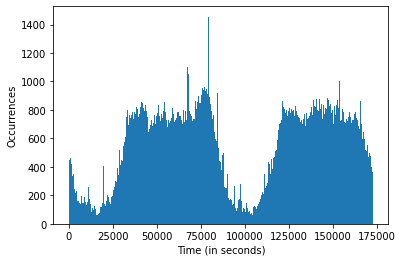

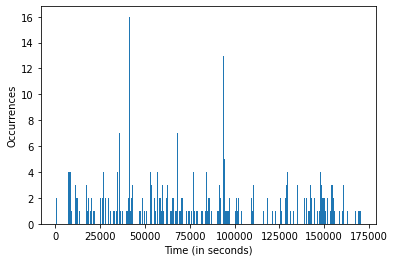

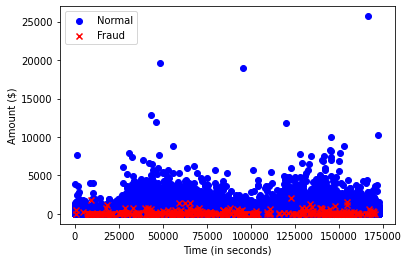

In [52]:
#Plot number of each class: data is skewed
plt.hist(data['Class'], bins = [-.4, .4, .6, 1.4], color = 'red')
plt.xlabel('Class')
plt.xticks([0, 1])
plt.ylabel('Occurrences')
plt.show()

print('Number of fraud transactions:', len(data[data['Class'] == 1]), '(', round(len(data[data['Class'] == 1])/len(data)*100, 2), '%)')
print('Number of non-fraud transactions:', len(data[data['Class'] == 0]), '(', round(len(data[data['Class'] == 0])/len(data)*100, 2), '%)')

#Ditrubution of transaction amounts
plt.hist(data['Amount'], bins = 500, color = 'red')
plt.xlabel('Amount ($)')
plt.ylabel('Occurrences')
plt.show()

#Distribution of fraudulent transaction amounts
plt.hist(data[data['Class'] == 1]['Amount'], bins = 500, color = 'red')
plt.xlabel('Amount ($)')
plt.ylabel('Occurrences')
plt.show()

#Distribution of transaction times
plt.hist(data['Time'], bins = 500)
plt.xlabel('Time (in seconds)')
plt.ylabel('Occurrences')
plt.show()

#Distribution of fraudulent transaction times
plt.hist(data[data['Class'] == 1]['Time'], bins = 500)
plt.xlabel('Time (in seconds)')
plt.ylabel('Occurrences')
plt.show()

#Time vs Amount Feature Plot
plt.scatter(data[data['Class'] == 0]['Time'], data[data['Class'] == 0]['Amount'], color = 'blue', label = 'Normal')
plt.scatter(data[data['Class'] == 1]['Time'], data[data['Class'] == 1]['Amount'], color = 'red', marker = 'x', label = 'Fraud')
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount ($)')
plt.legend()
plt.show()

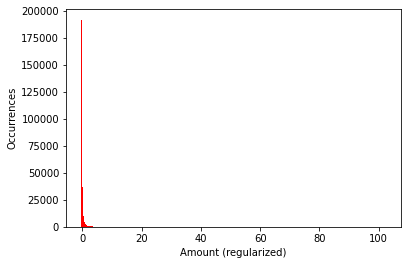

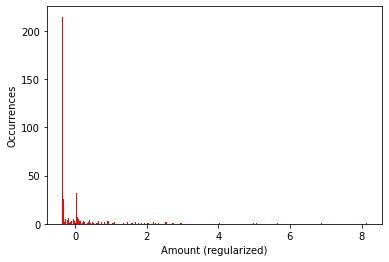

Min (scaled) amount: -0.35322939296682354


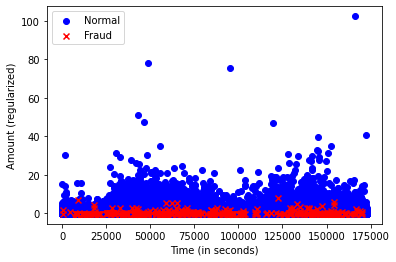

In [53]:
#Scaling time and amount features
std_scale = StandardScaler()
data['Amount'] = std_scale.fit_transform(data['Amount'].values.reshape(-1, 1))

#Plotting the scaled amount data to see if that improves visualization
plt.hist(data['Amount'], bins = 500, color = 'red')
plt.xlabel('Amount (regularized)')
plt.ylabel('Occurrences')
plt.show()

plt.hist(data[data['Class'] == 1]['Amount'], bins = 500, color = 'red')
plt.xlabel('Amount (regularized)')
plt.ylabel('Occurrences')
plt.show()
print('Min (scaled) amount:', data['Amount'].min())

plt.scatter(data[data['Class'] == 0]['Time'], data[data['Class'] == 0]['Amount'], color = 'blue', label = 'Normal')
plt.scatter(data[data['Class'] == 1]['Time'], data[data['Class'] == 1]['Amount'], color = 'red', marker = 'x', label = 'Fraud')
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount (regularized)')
plt.legend()
plt.show()


#### Undersample the Data to Balance the Classes

In [54]:
#Undersampling the dataset to balance the classes
frauds = data[data['Class'] == 1]
n_frauds = len(frauds)
fraud_indx = np.array(data[data['Class'] == 1].index)

#Randomly select numbeber of non-fraud transactions to match the number of fraud transactions
random_normal_indx = np.random.choice(data[data['Class'] == 0].index, n_frauds, replace = False)
random_normal_indx = np.array(random_normal_indx)

#Concatenate the indices of the normal and fraud transactions
undersample_indx = np.concatenate([fraud_indx, random_normal_indx])
undersample_data = data.iloc[undersample_indx]
undersample_data.head()

print("Percentage of Normal Transcations:", len(undersample_data[undersample_data['Class'] == 0])/len(undersample_data)*100, '%')
print("Percentage of Fraud Transcations:", len(undersample_data[undersample_data['Class'] == 1])/len(undersample_data)*100, '%')

#Split 
x = undersample_data.drop(['Class'], axis = 1)
y = undersample_data['Class']

Percentage of Normal Transcations: 50.0 %
Percentage of Fraud Transcations: 50.0 %


#### Cross Validation 

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

k = 5
k_fold = KFold(n_splits = k, shuffle = True, random_state = 4)
c = [0.01, 0.1, 1, 10, 100] #weight values to try

for i in range(len(c)):

    recall = np.zeros(k)
    precision = np.zeros(k)
    f1 = np.zeros(k)
    indx = 0
    for train_index, valid_index in k_fold.split(x_train):
        lr = LogisticRegression(C = c[i], penalty= "l2", max_iter= 1000) #Logistic Regression model
        Xtrain = x_train.iloc[train_index]
        Ytrain = y_train.iloc[train_index]
        lr.fit(Xtrain, Ytrain) #Fitting the model
        y_pred = lr.predict(x_train.iloc[valid_index]) #Predicting on the validation set

        #Evaluating the model
        recall[indx] = recall_score(y_train.iloc[valid_index], y_pred)
        precision[indx] = precision_score(y_train.iloc[valid_index], y_pred)
        f1[indx] = f1_score(y_train.iloc[valid_index], y_pred)
        indx += 1

    avg_recall = np.mean(recall)
    avg_precision = np.mean(precision)
    avg_f1 = np.mean(f1)
    print('C =', c[i], ', Recall:', avg_recall, 'Precision:', avg_precision, 'F1:', avg_f1)


C = 0.01 , Recall: 0.8879518569290834 Precision: 0.9837606837606838 F1: 0.9329819891128338
C = 0.1 , Recall: 0.8832883805474842 Precision: 0.9668867761648379 F1: 0.9229683446152037
C = 1 , Recall: 0.9056515084337187 Precision: 0.9599133038140384 F1: 0.9317563694638723
C = 10 , Recall: 0.9106515084337186 Precision: 0.9603084343373303 F1: 0.9345634071338296
C = 100 , Recall: 0.9056515084337187 Precision: 0.9576768164180409 F1: 0.9305935943804752
